In [16]:
from scipy.sparse.sputils import validateaxis
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

In [23]:
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
print(tf.test.is_gpu_available())

True


In [25]:
tf.test.is_built_with_cuda()

True

In [28]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY =r"F:/Projects/Mask Detection/mask detect/dataset"
CATEGORIES = ["with_mask","without_mask"]
print("[info] Loading images...")

data = []
labels =  []

for category in CATEGORIES:
    path =os.path.join(DIRECTORY,category)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image= load_img(img_path,target_size=(224,224))
        image= img_to_array(image)
        image= preprocess_input(image)

        data.append(image)
        labels.append(category)

lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels= to_categorical(labels)

data= np.array(data,dtype="float32")
labels =np.array(labels)

[info] Loading images...


C:\Users\ragha\anaconda3\envs\tf2.6\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [29]:
(train_X,test_X,train_Y,test_Y) = train_test_split(data, labels, test_size=0.20,stratify=labels, random_state=42)
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

basemodel = MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

headModel = basemodel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="Flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation="softmax")(headModel)

model = Model(inputs=basemodel.input,outputs=headModel)

for layer in basemodel.layers:
    layer.trainable=False


In [30]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR,decay= INIT_LR/EPOCHS)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

print("[INFO] training head...")
H= model.fit(aug.flow(train_X,train_Y,batch_size=BS),
            steps_per_epoch=len(train_X)//BS,
            validation_data=(test_X,test_Y),
            validation_steps=len(test_X) // BS,
            epochs=EPOCHS)
        
print("[INFO] evaluating network...")
predIdxs = model.predict(test_X,batch_size=BS)

predIdxs = np.argmax(predIdxs,axis = 1)
print(classification_report(test_Y.argmax(axis=1),predIdxs,target_names=lb.classes_))

print("[INFO] saving mask detect...")
model.save("mask_detect.model",save_format="h5")

[INFO] compiling model...
[INFO] training head...


C:\Users\ragha\anaconda3\envs\tf2.6\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
95/95 [==============================] - 35s 352ms/step - loss: 0.6719 - accuracy: 0.7113 - val_loss: 0.4549 - val_accuracy: 0.8957
Epoch 2/20
95/95 [==============================] - 30s 314ms/step - loss: 0.4583 - accuracy: 0.8556 - val_loss: 0.3237 - val_accuracy: 0.9544
Epoch 3/20
95/95 [==============================] - 31s 323ms/step - loss: 0.3646 - accuracy: 0.9074 - val_loss: 0.2459 - val_accuracy: 0.9713
Epoch 4/20
95/95 [==============================] - 27s 287ms/step - loss: 0.2868 - accuracy: 0.9357 - val_loss: 0.1985 - val_accuracy: 0.9804
Epoch 5/20
95/95 [==============================] - 29s 304ms/step - loss: 0.2471 - accuracy: 0.9410 - val_loss: 0.1649 - val_accuracy: 0.9844
Epoch 6/20
95/95 [==============================] - 27s 282ms/step - loss: 0.2109 - accuracy: 0.9539 - val_loss: 0.1428 - val_accuracy: 0.9870
Epoch 7/20
95/95 [==============================] - 28s 296ms/step - loss: 0.1811 - accuracy: 0.9657 - val_loss: 0.1259 - val_accuracy: 0.9883

C:\Users\ragha\anaconda3\envs\tf2.6\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


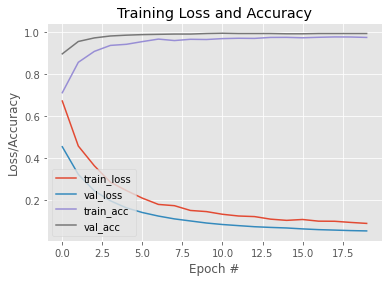

In [31]:
N=EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")